# Tutorial demonstrating the basic functionality of the `iwatlas` package

In this tutorial we will learn how to:

 - Download the data netcdf4 file
 - Make a point velocity time-series prediction
 - Make a prediction of velocity over a spatial region
 
---

 

In [1]:
# These are the sub-modules in the iwatlas package that we will use
from iwatlas import sshdriver
from iwatlas import uvdriver
from iwatlas import harmonics
from iwatlas import stratification as strat
from iwatlas import iwaves

import xarray as xr
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

In [2]:
# Uncomment this option to allow for interactive plot windows (e.g. zooming)
# %matplotlib notebook

In [3]:
# Set where you want to download the 200 MB data file
# basedir = '/home/jupyter-ubuntu/data/iwatlas'
basedir = '../DATA'

In [4]:
%%time
# Download the data if it does not exist
import urllib, os

# Link to a 200 MB data file on cloudstor
# publicurl = 'https://cloudstor.aarnet.edu.au/plus/s/vdksw5WKFOTO0nD/download'
publicurl = 'https://research-repository.uwa.edu.au/files/93942498/NWS_2km_GLORYS_hex_2013_2014_InternalWave_Atlas.nc'
atlasfile = '{}/NWS_2km_GLORYS_hex_2013_2014_InternalWave_Atlas.nc'.format(basedir)

if os.path.exists(basedir):
    print('Folder exists.')
else:
    print('Making folder {}'.format(basedir))
    os.mkdir(basedir)
    
if os.path.exists(atlasfile):
    print('File exists.')
else:
    print('Downloading file...')
    urllib.request.urlretrieve (publicurl, atlasfile)
    print('Done. Saved to {}'.format(atlasfile))
atlasfile

Making folder /home/jupyter-ubuntu/data/iwatlas
Done. Saved to /home/jupyter-ubuntu/data/iwatlas/NWS_2km_GLORYS_hex_2013_2014_InternalWave_Atlas.nc
CPU times: user 848 ms, sys: 821 ms, total: 1.67 s
Wall time: 9.01 s


'/home/jupyter-ubuntu/data/iwatlas/NWS_2km_GLORYS_hex_2013_2014_InternalWave_Atlas.nc'

In [5]:
# Load the atlas file as an object
ssh = sshdriver.load_ssh_clim(atlasfile)
ssh

<xarray.Dataset>
Dimensions:     (Nc: 225368, numsides: 8, Np: 454016, Nmode: 4, Nk: 80, Nkw: 81, Nannual: 4, Nparams: 7, Ntide: 35)
Coordinates:
    xv          (Nc) float64 ...
    yv          (Nc) float64 ...
    Nk          (Nc) int32 74 76 76 75 73 74 77 76 ... 79 79 79 79 79 79 79 79
    z_w         (Nkw) float64 ...
    omegaA      (Nannual) float64 ...
    params      (Nparams) int64 ...
    omega       (Ntide) float64 ...
Dimensions without coordinates: Nc, numsides, Np, Nmode, Nkw, Nannual, Nparams, Ntide
Data variables: (12/15)
    cells       (Nc, numsides) int32 3058 3061 3060 2801 ... 316184 316187 -1 -1
    xp          (Np) float64 1.394e+07 1.271e+07 ... 1.303e+07 1.303e+07
    yp          (Np) float64 -1.619e+06 -2.553e+06 ... -2.056e+06 -2.055e+06
    nfaces      (Nc) int32 ...
    dv          (Nc) float64 ...
    modes       (Nmode) float64 ...
    ...          ...
    N2_re       (Nannual, Nparams, Nc) float64 ...
    N2_im       (Nannual, Nparams, Nc) float64 ...
 

In [7]:
# WA-IMOS locations (August 2019)
sites = {
'NIN100':{'y':-21.84986667,'x':113.9064667},
'NWSBAR':{'y':-20.76128333,'x':114.7586167},
'NWSROW':{'y':-17.75801667,'x':119.9061},
'NWSBRW':{'y':-14.23543333,'x':123.1623833},
'NWSLYN':{'y':-9.939416667,'x':130.3490833},
'PIL200':{'x': 115.9154, 'y':-19.435333}   ,
'KIM200':{'x':121.243217 , 'y':-15.534517} ,  
'KIM400':{'x': 121.114967, 'y':-15.22125}   ,
'ITFTIS':{'x': 127.5577, 'y':-9.819217}   ,
'BB250':{'x':123.34613 , 'y':-13.75897}  ,
'Prelude':{'x':123.3506, 'y':-13.7641} , 
}

# Example 1: baroclinic velocity prediciton at a point

In [69]:
# Site of interest
xpt = sites['Prelude']['x']
ypt = sites['Prelude']['y']

# Prediction time
timeout = pd.date_range('2021-08-01','2021-09-01',freq='1H').values

In [70]:
%%time
# Compute the velocity as a function of z 
# this requires calculating vertical mode function for every time step so may take a minute or two
uz, vz, zout = uvdriver.predict_uv_z(ssh, np.array([xpt]), np.array([ypt]), timeout)

/home/jupyter-ubuntu/code/iwatlas/iwatlas/stratification.py:94: RuntimeWarning: divide by zero encountered in log
  zpr = -np.log(zout)


CPU times: user 12.9 s, sys: 292 ms, total: 13.2 s
Wall time: 13.2 s


In [71]:
# Output arrays are size (Nz, Nxy, Nt)
uz.shape, zout.shape 

((80, 1, 745), (80, 1, 745))

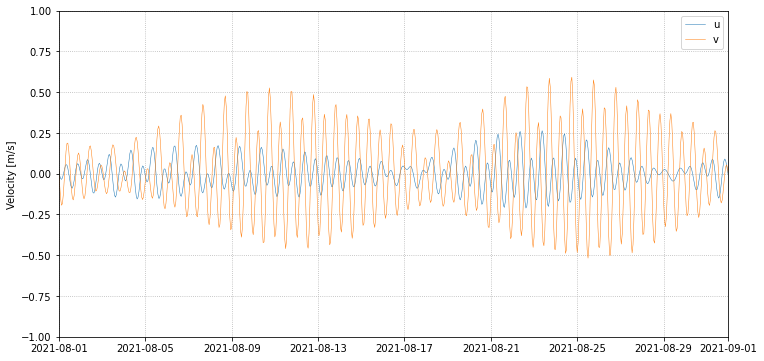

In [72]:
# Plot the surface velocity
usurf = uz[0,0,...]
vsurf = vz[0,0,...]

plt.figure(figsize=(12,6))
plt.plot(timeout, usurf,lw=0.5)
plt.plot(timeout, vsurf,lw=0.5)
plt.ylabel('Velocity [m/s]')
plt.legend(('u','v'))
plt.ylim(-1,1)
plt.xlim(timeout[0],timeout[-1])
plt.grid(b=True,ls=':')


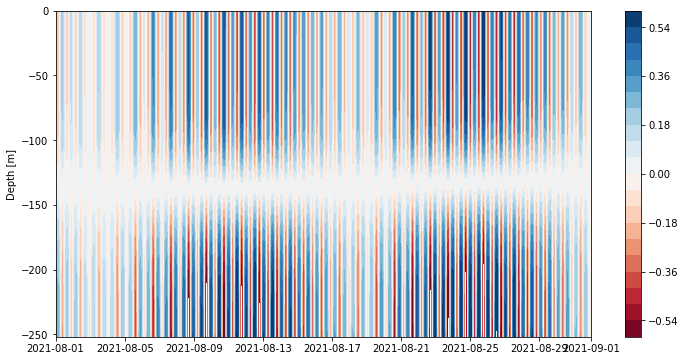

In [73]:
# z-t contour plot of velocity
plt.figure(figsize=(12,6))
plt.contourf(timeout, -zout[:,0,0].squeeze(), vz.squeeze(), np.linspace(-0.6,0.6,21),  cmap='RdBu')
plt.ylabel('Depth [m]')
plt.xlim(timeout[0],timeout[-1])
plt.colorbar()

In [86]:
# Output the surface velocity to a csv file
df = pd.DataFrame({'u [m/s]':usurf,'v [m/s]':vsurf},index=timeout)
outfile = '{}/IWATLAS_velocity_example.csv'.format(basedir)
df.to_csv(outfile)
print('Velocity prediction written to:\n\t{}'.format(outfile))
df

Velocity prediction written to:
	/home/jupyter-ubuntu/data/iwatlas/IWATLAS_velocity_example.csv


,u [m/s],v [m/s]
2021-08-01 00:00:00,0.012425,0.028194
2021-08-01 01:00:00,-0.012283,-0.073176
2021-08-01 02:00:00,-0.029668,-0.153479
2021-08-01 03:00:00,-0.034524,-0.193212
2021-08-01 04:00:00,-0.025371,-0.183391
...,...,...
2021-08-31 20:00:00,0.090109,0.002664
2021-08-31 21:00:00,0.079176,0.042228
2021-08-31 22:00:00,0.051218,0.053460
2021-08-31 23:00:00,0.016236,0.035083


# Example 2: surface baroclinic velocity over a region


In [44]:
dx = 0.02 # 2 km
x = np.arange(xpt-0.25, xpt+0.25+dx,dx)
y = np.arange(ypt-0.25, ypt+0.25+dx,dx)

X, Y = np.meshgrid(x,y)

# Prediction time
timeout = np.datetime64('2021-08-12 09:00:00')

In [45]:
%%time
# Compute the velocity as a function of z 
# this requires calculating vertical mode function for every time step so may take a minute or two
uz, vz, zout = uvdriver.predict_uv_z(ssh, X.ravel(), Y.ravel(), np.array([timeout]))

CPU times: user 12.1 s, sys: 660 ms, total: 12.7 s
Wall time: 12.7 s


In [48]:
# uz has shape Nz, Nxy, Nt

# Extract the surface velocity and reshape
us = uz[0,...,0].reshape(X.shape)
vs = vz[0,...,0].reshape(X.shape)

Text(0.5, 1.0, '2021-08-12T09:00:00')

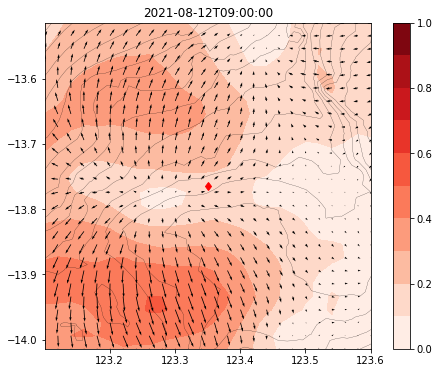

In [66]:
# Make a contour plot of speed with vectors overlaid
speed = np.abs(us + 1j*vs)
plt.figure(figsize=(8,6))
plt.contourf(X, Y, speed, np.arange(0,1.1, 0.1), cmap='Reds')
plt.colorbar()
plt.quiver(X, Y, us, vs)
# Overlay the depth contours
ssh.contourf(ssh._ds['dv'],np.arange(100,400,10), 
        colors='k', linewidths=0.2, filled=False, colorbar=False, xlims=[x[0],x[-1]], ylims=[y[0],y[-1]])

plt.plot(xpt, ypt,'rd')
plt.gca().set_aspect('equal')
plt.title(timeout)